In [1]:

import numpy as np
import wandb
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
#from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython import display as ipythondisplay
from PIL import Image

In [2]:
gym.__version__

'0.26.2'

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ed21b044 (navinboys). Use `wandb login --relogin` to force relogin


True

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size

GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate



class QNetwork1(nn.Module):

    def __init__(self,fc1_units, fc2_units,type,state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.advantage_fc = nn.Linear(fc2_units, action_size)
        self.value_fc = nn.Linear(fc2_units, 1)
        self.type = type

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        advantage = self.advantage_fc(x)
        value = self.value_fc(x)
        if self.type == 1:
            q_values = value + (advantage - advantage.mean(dim = 1, keepdim = True))
        else:
            q_values = value + (advantage - torch.max(advantage))
        return q_values
    
    

In [5]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
from scipy.special import softmax

class TutorialAgent():
    def __init__(self,lr,Batch_Size,update_rate,type,state_size, action_size,fc1 =128, fc2= 64, seed = 0):
        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = Batch_Size
        self.seed = random.seed(seed)
        self.qnetwork_local = QNetwork1(int(fc1),int(fc2),type,state_size, action_size).to(device)
        self.qnetwork_target = QNetwork1(int(fc1),int(fc2),type,state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, int(Batch_Size), seed)
        self.t_step = 0
        self.update_rate = int(update_rate)
        

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
        self.t_step = (self.t_step + 1) % self.update_rate
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, policy, hyp=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if(policy == "eps greedy"):
          if random.random() > hyp:
              return np.argmax(action_values.cpu().data.numpy())
          else:
              return random.choice(np.arange(self.action_size))
        if(policy == "softmax"):
          action_probs = softmax(action_values.cpu().data.numpy().flatten() / hyp)
          return np.random.choice(np.arange(self.action_size), p=action_probs)

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    ''' Trial run to check if algorithm runs and saves the data '''

class DuelingDQN:
    def __init__(self,env, policy, agent):
        self.env = env
        self.episodes = 4000
        self.max_t = 10000
        self.policy = policy
        self.agent = agent

    def train(self):
        hyp_start = 1.0
        hyp_end = 0.01
        hyp_decay = 0.995
        hyp = hyp_start
        scores_window = deque(maxlen=100)
        avg_rewards = []
        for i_episode in range(1, self.episodes+1):
            state,_ = self.env.reset()
            score = 0
            for t in range(self.max_t):
                action = self.agent.act(state, self.policy, hyp = hyp)
                next_state, reward, done, _, _ = self.env.step(action)
                self.agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                 break
            scores_window.append(score)
            hyp = max(hyp_end, hyp_decay*hyp)
            ''' decrease epsilon '''
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            avg_rewards.append(np.mean(scores_window))
            if i_episode % 10 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if i_episode >300:
            
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                break
            regret = self.regret(avg_rewards)
        return regret, avg_rewards
    
    def run(self):
        hyp_start = 1.0
        hyp_end = 0.01
        hyp_decay = 0.995
        hyp = hyp_start
        scores_window = deque(maxlen=100)
        avg_rewards = []
        for i_episode in range(1, self.episodes+1):
            state,_ = self.env.reset()
            score = 0
            for t in range(self.max_t):
                action = self.agent.act(state, self.policy, hyp = hyp)
                next_state, reward, done, _, _ = self.env.step(action)
                state = next_state
                score += reward
                if done:
                 break
            if score > 500:
                score= 500
            scores_window.append(score)
            hyp = max(hyp_end, hyp_decay*hyp)
            ''' decrease epsilon '''
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            avg_rewards.append(np.mean(scores_window))
            if i_episode % 10 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if i_episode >350:
            
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                break
            regret = self.regret(avg_rewards)
        return regret, avg_rewards
    
    def regret(self,rewards):
        regret = 0
        for i in range(len(rewards)):
            regret += self.env.spec.reward_threshold - rewards[i]
        return regret

    
        


In [7]:
lr2 = 0.001
batch2 = 68
lr1 = 0.0003763
batch1 = 56
update = 14  
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent1 = TutorialAgent(lr1,batch1,update,1,state_size,action_size, seed = 0)
agent2 = TutorialAgent(lr2,batch2,update,2,state_size,action_size, seed = 0)

In [8]:
DDQN1 = DuelingDQN(env,"eps greedy",agent1)
DDQN1.train()

Episode 10	Average Score: 24.50
Episode 20	Average Score: 28.55
Episode 30	Average Score: 26.13
Episode 40	Average Score: 23.90
Episode 50	Average Score: 22.74
Episode 60	Average Score: 22.17
Episode 70	Average Score: 21.20
Episode 80	Average Score: 20.62
Episode 90	Average Score: 19.97
Episode 100	Average Score: 19.44
Episode 110	Average Score: 18.34
Episode 120	Average Score: 16.43
Episode 130	Average Score: 15.76
Episode 140	Average Score: 15.42
Episode 150	Average Score: 15.68
Episode 160	Average Score: 20.86
Episode 170	Average Score: 27.68
Episode 180	Average Score: 32.15
Episode 190	Average Score: 40.38
Episode 200	Average Score: 51.39
Episode 210	Average Score: 59.39
Episode 220	Average Score: 68.68
Episode 230	Average Score: 77.65
Episode 240	Average Score: 89.53
Episode 250	Average Score: 104.08
Episode 260	Average Score: 119.95
Episode 270	Average Score: 131.28
Episode 280	Average Score: 143.00
Episode 290	Average Score: 150.01
Episode 300	Average Score: 153.68
Episode 301	A

(127293.11465121523,
 [12.0,
  14.5,
  14.333333333333334,
  23.0,
  30.0,
  30.666666666666668,
  28.428571428571427,
  26.375,
  25.333333333333332,
  24.5,
  30.818181818181817,
  29.083333333333332,
  28.53846153846154,
  29.0,
  28.466666666666665,
  27.625,
  27.58823529411765,
  28.27777777777778,
  28.63157894736842,
  28.55,
  27.714285714285715,
  27.09090909090909,
  26.52173913043478,
  26.208333333333332,
  26.52,
  26.5,
  26.40740740740741,
  26.357142857142858,
  26.0,
  26.133333333333333,
  26.032258064516128,
  25.5625,
  25.151515151515152,
  24.794117647058822,
  24.428571428571427,
  24.47222222222222,
  24.243243243243242,
  23.973684210526315,
  23.794871794871796,
  23.9,
  23.658536585365855,
  23.404761904761905,
  23.13953488372093,
  22.90909090909091,
  22.622222222222224,
  22.565217391304348,
  22.53191489361702,
  22.3125,
  22.346938775510203,
  22.74,
  22.647058823529413,
  22.46153846153846,
  22.452830188679247,
  22.462962962962962,
  22.472727272

In [9]:
DDQN2 = DuelingDQN(env,"eps greedy",agent2)
DDQN2.train()

Episode 10	Average Score: 28.40
Episode 20	Average Score: 24.00
Episode 30	Average Score: 24.00
Episode 40	Average Score: 24.57
Episode 50	Average Score: 25.68
Episode 60	Average Score: 29.93
Episode 70	Average Score: 33.24
Episode 80	Average Score: 34.92
Episode 90	Average Score: 37.97
Episode 100	Average Score: 39.60
Episode 110	Average Score: 45.68
Episode 120	Average Score: 52.21
Episode 130	Average Score: 58.87
Episode 140	Average Score: 65.93
Episode 150	Average Score: 78.05
Episode 160	Average Score: 87.60
Episode 170	Average Score: 97.16
Episode 180	Average Score: 109.47
Episode 190	Average Score: 123.52
Episode 200	Average Score: 134.15
Episode 210	Average Score: 139.97
Episode 220	Average Score: 145.02
Episode 230	Average Score: 147.94
Episode 240	Average Score: 157.51
Episode 250	Average Score: 157.79
Episode 260	Average Score: 159.44
Episode 270	Average Score: 167.10
Episode 280	Average Score: 175.65
Episode 290	Average Score: 190.72
Episode 300	Average Score: 199.48
Episod

(115236.20613411079,
 [64.0,
  42.0,
  35.333333333333336,
  34.75,
  31.0,
  28.0,
  28.857142857142858,
  29.375,
  28.444444444444443,
  28.4,
  27.545454545454547,
  26.833333333333332,
  26.307692307692307,
  26.214285714285715,
  26.0,
  25.8125,
  25.58823529411765,
  25.166666666666668,
  24.57894736842105,
  24.0,
  23.571428571428573,
  23.454545454545453,
  23.91304347826087,
  23.875,
  23.32,
  23.307692307692307,
  22.962962962962962,
  23.642857142857142,
  24.03448275862069,
  24.0,
  24.0,
  24.53125,
  24.424242424242426,
  25.294117647058822,
  25.2,
  25.166666666666668,
  24.89189189189189,
  24.789473684210527,
  24.974358974358974,
  24.575,
  25.804878048780488,
  25.833333333333332,
  26.046511627906977,
  25.795454545454547,
  25.8,
  25.52173913043478,
  25.659574468085108,
  25.604166666666668,
  25.408163265306122,
  25.68,
  26.03921568627451,
  26.596153846153847,
  27.37735849056604,
  27.75925925925926,
  27.672727272727272,
  28.482142857142858,
  28.5

Training

In [10]:
def PerformExpmt(num_expmt):
        reward_avgs = []
        for i in range(num_expmt):  
            print("Experiment: %d"%(i+1))
            regret,rewards = DDQN1.run()   
            reward_avgs.append(np.asarray(rewards))
        mean_base = np.mean(np.array(reward_avgs), axis=0)
        std_base = np.std(reward_avgs, axis=0)

        reward_avgs = []
        for i in range(num_expmt):  
            print("Experiment: %d"%(i+1))
            regret,rewards = DDQN2.run()   
            reward_avgs.append(np.asarray(rewards))
        mean_wbase = np.mean(np.array(reward_avgs), axis=0)
        std_wbase = np.std(reward_avgs, axis=0)
        return mean_base, std_base, mean_wbase, std_wbase

mean_base, std_base, mean_wbase, std_wbase = PerformExpmt(5)

Experiment: 1
Episode 10	Average Score: 22.60
Episode 20	Average Score: 28.25
Episode 30	Average Score: 27.93
Episode 40	Average Score: 26.55
Episode 50	Average Score: 28.30
Episode 60	Average Score: 28.28
Episode 70	Average Score: 33.76
Episode 80	Average Score: 35.30
Episode 90	Average Score: 38.08
Episode 100	Average Score: 41.74
Episode 110	Average Score: 49.28
Episode 120	Average Score: 57.29
Episode 130	Average Score: 67.28
Episode 140	Average Score: 74.51
Episode 150	Average Score: 82.04
Episode 160	Average Score: 89.83
Episode 170	Average Score: 96.90
Episode 180	Average Score: 109.85
Episode 190	Average Score: 118.36
Episode 200	Average Score: 124.89
Episode 210	Average Score: 129.50
Episode 220	Average Score: 135.29
Episode 230	Average Score: 139.50
Episode 240	Average Score: 146.24
Episode 250	Average Score: 152.03
Episode 260	Average Score: 156.61
Episode 270	Average Score: 156.28
Episode 280	Average Score: 156.08
Episode 290	Average Score: 157.96
Episode 300	Average Score:

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-73 (_run_job), stopped 139009861854784)>>
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap
    self._bootstrap_inner()
  File "/usr/lib/python3.10/threading.py", line 1018, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/usr/lib/python3.10/threading.py", line 1336, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/home/navin/.local/lib/python3.10/site-packages/ipykernel/iostream.py", line 604, in flush
    self.pub_thread.schedule(self._flush)
  File "/home/navin/.local/lib/python3.10/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/home/navin/.local/lib/python3.10/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "z

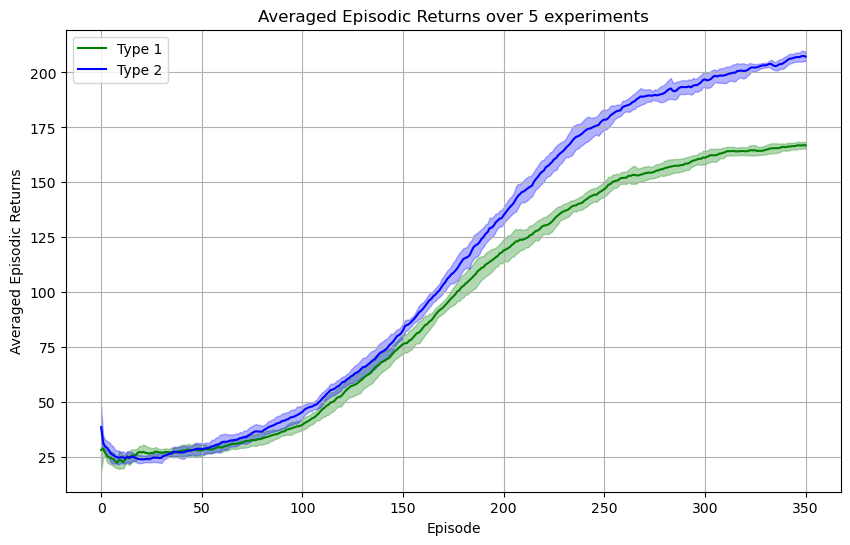

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(351), mean_base, label='Type 1', color='green')
plt.fill_between(range(351), mean_base - std_base, mean_base + std_base, alpha=0.3, color='green')
plt.plot(range(351), mean_wbase, label='Type 2', color='blue')
plt.fill_between(range(351), mean_wbase - std_wbase, mean_wbase + std_wbase, alpha=0.3, color='blue')
plt.xlabel('Episode')
plt.ylabel('Averaged Episodic Returns')
plt.title("Averaged Episodic Returns over 5 experiments")
plt.legend()
plt.grid()
plt.savefig('withoutbaseline.png')
plt.show()

Running Expmts

Tuning

In [12]:
def Objective(lr,batch,update):
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    type = 2 #mean
    # type  = 2 # max
    agent = TutorialAgent(lr,batch,update,type,state_size,action_size, seed = 0)
    DDQN = DuelingDQN(env,"eps greedy",agent)
    regret, avg_rewards = DDQN.train()
    return regret, avg_rewards

sweep_config = {
    'method': 'bayes'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'lr': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.00001,
        'max': 0.01
      },
    'batch': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 40,
        'max': 80
      },
    'update1': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 20,
        'max': 30
      }
    }

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="dqCart-V1")

def train(config=sweep_config):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        regret, avg_reward = Objective(config.lr,config.batch,config.update1)


        for epoch in range(len(avg_reward)):
            wandb.log({"Score": avg_reward[epoch], "epoch": epoch})  
        wandb.log({"Regret": regret}) 

wandb.agent(sweep_id, train, count=7)

Create sweep with ID: u9kp5kms
Sweep URL: https://wandb.ai/navinboys/dqCart-V1/sweeps/u9kp5kms


wandb: Agent Starting Run: n8973i90 with config:
wandb: 	batch: 48.70249057889289
wandb: 	lr: 0.00602492191007833
wandb: 	optimizer: sgd
wandb: 	update1: 23.27953721068106
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 18.70
Episode 20	Average Score: 21.90
Episode 30	Average Score: 28.23
Episode 40	Average Score: 27.05
Episode 50	Average Score: 29.26
Episode 60	Average Score: 29.35
Episode 70	Average Score: 30.16
Episode 80	Average Score: 29.45
Episode 90	Average Score: 29.34
Episode 100	Average Score: 30.48
Episode 110	Average Score: 32.44
Episode 120	Average Score: 34.44
Episode 130	Average Score: 33.55
Episode 140	Average Score: 35.70
Episode 150	Average Score: 38.43
Episode 160	Average Score: 40.77
Episode 170	Average Score: 41.47
Episode 180	Average Score: 43.18
Episode 190	Average Score: 44.78
Episode 200	Average Score: 50.37
Episode 210	Average Score: 56.70
Episode 220	Average Score: 60.90
Episode 230	Average Score: 67.51
Episode 240	Average Score: 72.75
Episode 250	Average Score: 82.27
Episode 260	Average Score: 87.50
Episode 270	Average Score: 100.71
Episode 280	Average Score: 108.08
Episode 290	Average Score: 111.75
Episode 300	Average Score: 104.96
Episode 301	Ave

Regret,▁
Score,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▇███▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,127697.80166
Score,103.82
epoch,300


wandb: Agent Starting Run: 682l0y0r with config:
wandb: 	batch: 60.154355603609744
wandb: 	lr: 0.00185600385241123
wandb: 	optimizer: sgd
wandb: 	update1: 28.8688534526864
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 34.90
Episode 20	Average Score: 30.40
Episode 30	Average Score: 30.90
Episode 40	Average Score: 33.80
Episode 50	Average Score: 34.60
Episode 60	Average Score: 35.02
Episode 70	Average Score: 36.87
Episode 80	Average Score: 38.11
Episode 90	Average Score: 43.54
Episode 100	Average Score: 46.49
Episode 110	Average Score: 49.52
Episode 120	Average Score: 55.57
Episode 130	Average Score: 62.27
Episode 140	Average Score: 67.88
Episode 150	Average Score: 73.82
Episode 160	Average Score: 82.21
Episode 170	Average Score: 89.64
Episode 180	Average Score: 93.34
Episode 190	Average Score: 97.68
Episode 200	Average Score: 108.12
Episode 210	Average Score: 120.92
Episode 220	Average Score: 132.06
Episode 230	Average Score: 139.41
Episode 240	Average Score: 155.74
Episode 250	Average Score: 162.56
Episode 260	Average Score: 158.91
Episode 270	Average Score: 148.56
Episode 280	Average Score: 141.21
Episode 290	Average Score: 129.25
Episode 300	Average Score: 112.65
Episode 

Regret,▁
Score,▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▇▇▇███▇▇▇▆▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,117412.57143
Score,110.88
epoch,300


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k5ey0qg3 with config:
wandb: 	batch: 70.44029892850905
wandb: 	lr: 0.00675272265087345
wandb: 	optimizer: adam
wandb: 	update1: 24.24584901787047
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 23.00
Episode 20	Average Score: 21.90
Episode 30	Average Score: 20.87
Episode 40	Average Score: 22.55
Episode 50	Average Score: 28.46
Episode 60	Average Score: 30.53
Episode 70	Average Score: 31.44
Episode 80	Average Score: 32.04
Episode 90	Average Score: 33.76
Episode 100	Average Score: 33.90
Episode 110	Average Score: 36.29
Episode 120	Average Score: 37.49
Episode 130	Average Score: 39.27
Episode 140	Average Score: 42.31
Episode 150	Average Score: 42.93
Episode 160	Average Score: 42.30
Episode 170	Average Score: 46.53
Episode 180	Average Score: 52.43
Episode 190	Average Score: 56.96
Episode 200	Average Score: 59.16
Episode 210	Average Score: 57.82
Episode 220	Average Score: 56.30
Episode 230	Average Score: 54.84
Episode 240	Average Score: 50.24
Episode 250	Average Score: 45.58
Episode 260	Average Score: 43.18
Episode 270	Average Score: 36.37
Episode 280	Average Score: 27.92
Episode 290	Average Score: 19.86
Episode 300	Average Score: 15.26
Episode 301	Average

Regret,▁
Score,▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇█████▇▇▆▆▅▅▃▃▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,131085.25669
Score,14.78
epoch,300


wandb: Agent Starting Run: 41m34b8q with config:
wandb: 	batch: 47.11182122420987
wandb: 	lr: 0.002907885424703804
wandb: 	optimizer: sgd
wandb: 	update1: 27.98756975372489
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 22.40
Episode 20	Average Score: 24.40
Episode 30	Average Score: 29.27
Episode 40	Average Score: 30.43
Episode 50	Average Score: 31.86
Episode 60	Average Score: 32.52
Episode 70	Average Score: 34.83
Episode 80	Average Score: 35.84
Episode 90	Average Score: 39.96
Episode 100	Average Score: 40.26
Episode 110	Average Score: 45.32
Episode 120	Average Score: 52.43
Episode 130	Average Score: 55.63
Episode 140	Average Score: 61.33
Episode 150	Average Score: 61.32
Episode 160	Average Score: 59.30
Episode 170	Average Score: 55.58
Episode 180	Average Score: 52.57
Episode 190	Average Score: 46.47
Episode 200	Average Score: 51.77
Episode 210	Average Score: 54.89
Episode 220	Average Score: 49.67
Episode 230	Average Score: 43.76
Episode 240	Average Score: 35.78
Episode 250	Average Score: 33.25
Episode 260	Average Score: 33.52
Episode 270	Average Score: 33.94
Episode 280	Average Score: 33.97
Episode 290	Average Score: 33.86
Episode 300	Average Score: 25.24
Episode 301	Average

Regret,▁
Score,▂▁▁▂▂▂▃▃▃▃▄▄▄▄▅▆▇▇████▇▇▆▅▆▇▇▆▅▄▃▃▃▃▃▃▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,130099.43536
Score,24.52
epoch,300


wandb: Agent Starting Run: y9294xd3 with config:
wandb: 	batch: 51.30229030505474
wandb: 	lr: 0.00835381286648672
wandb: 	optimizer: adam
wandb: 	update1: 23.998239543629577
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 14.90
Episode 20	Average Score: 16.65
Episode 30	Average Score: 18.87
Episode 40	Average Score: 20.88
Episode 50	Average Score: 21.70
Episode 60	Average Score: 24.18
Episode 70	Average Score: 27.00
Episode 80	Average Score: 28.66
Episode 90	Average Score: 27.91
Episode 100	Average Score: 30.23
Episode 110	Average Score: 32.11
Episode 120	Average Score: 34.78
Episode 130	Average Score: 37.31
Episode 140	Average Score: 39.53
Episode 150	Average Score: 42.92
Episode 160	Average Score: 44.12
Episode 170	Average Score: 46.19
Episode 180	Average Score: 47.81
Episode 190	Average Score: 55.96
Episode 200	Average Score: 62.24
Episode 210	Average Score: 73.88
Episode 220	Average Score: 76.75
Episode 230	Average Score: 76.32
Episode 240	Average Score: 72.55
Episode 250	Average Score: 67.70
Episode 260	Average Score: 64.02
Episode 270	Average Score: 58.77
Episode 280	Average Score: 54.99
Episode 290	Average Score: 46.92
Episode 300	Average Score: 36.63
Episode 301	Average

Regret,▁
Score,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▆▆▇████▇▇▆▆▆▅▄▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,129559.39128
Score,35.17
epoch,300


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1we4dj2a with config:
wandb: 	batch: 72.09822084377859
wandb: 	lr: 0.009377903330522849
wandb: 	optimizer: adam
wandb: 	update1: 22.183512446897673
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 25.90
Episode 20	Average Score: 26.95
Episode 30	Average Score: 26.10
Episode 40	Average Score: 29.40
Episode 50	Average Score: 30.18
Episode 60	Average Score: 31.18
Episode 70	Average Score: 30.66
Episode 80	Average Score: 31.75
Episode 90	Average Score: 31.96
Episode 100	Average Score: 32.70
Episode 110	Average Score: 35.56
Episode 120	Average Score: 38.78
Episode 130	Average Score: 43.43
Episode 140	Average Score: 49.06
Episode 150	Average Score: 53.20
Episode 160	Average Score: 54.88
Episode 170	Average Score: 61.59
Episode 180	Average Score: 64.31
Episode 190	Average Score: 70.58
Episode 200	Average Score: 75.61
Episode 210	Average Score: 79.14
Episode 220	Average Score: 79.74
Episode 230	Average Score: 80.12
Episode 240	Average Score: 72.64
Episode 250	Average Score: 68.26
Episode 260	Average Score: 63.98
Episode 270	Average Score: 55.56
Episode 280	Average Score: 50.88
Episode 290	Average Score: 44.19
Episode 300	Average Score: 36.31
Episode 301	Average

Regret,▁
Score,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▇▇█▇██▇▇▆▆▅▅▄▄▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,127825.43559
Score,36.15
epoch,300


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: meav3r6f with config:
wandb: 	batch: 68.34887821722748
wandb: 	lr: 0.0017447172195843234
wandb: 	optimizer: sgd
wandb: 	update1: 22.220909328135264
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 15.00
Episode 20	Average Score: 17.10
Episode 30	Average Score: 24.33
Episode 40	Average Score: 23.88
Episode 50	Average Score: 26.64
Episode 60	Average Score: 29.20
Episode 70	Average Score: 32.21
Episode 80	Average Score: 35.71
Episode 90	Average Score: 37.33
Episode 100	Average Score: 41.02
Episode 110	Average Score: 48.09
Episode 120	Average Score: 59.62
Episode 130	Average Score: 66.61
Episode 140	Average Score: 77.52
Episode 150	Average Score: 85.81
Episode 160	Average Score: 94.03
Episode 170	Average Score: 101.11
Episode 180	Average Score: 109.38
Episode 190	Average Score: 114.67
Episode 200	Average Score: 117.16
Episode 210	Average Score: 124.46
Episode 220	Average Score: 120.65
Episode 230	Average Score: 119.94
Episode 240	Average Score: 124.18
Episode 250	Average Score: 128.93
Episode 260	Average Score: 136.04
Episode 270	Average Score: 156.47
Episode 280	Average Score: 176.23
Episode 290	Average Score: 198.77
Episode 300	Average Score: 205.09
Episo

Regret,▁
Score,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▇▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,116884.18858
Score,204.54
epoch,300


In [13]:
def Objective(lr,batch,update):
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    type = 1 #mean
    # type  = 2 # max
    agent = TutorialAgent(lr,batch,update,type,state_size,action_size, seed = 0)
    DDQN = DuelingDQN(env,"eps greedy",agent)
    regret, avg_rewards = DDQN.train()
    return regret, avg_rewards

sweep_config = {
    'method': 'bayes'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'lr': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.00001,
        'max': 0.01
      },
    'batch': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 40,
        'max': 80
      },
    'update1': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 20,
        'max': 30
      }
    }

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="dqCart-V1")

def train(config=sweep_config):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        regret, avg_reward = Objective(config.lr,config.batch,config.update1)


        for epoch in range(len(avg_reward)):
            wandb.log({"Score": avg_reward[epoch], "epoch": epoch})  
        wandb.log({"Regret": regret}) 

wandb.agent(sweep_id, train, count=7)

Create sweep with ID: 3at1jpps
Sweep URL: https://wandb.ai/navinboys/dqCart-V1/sweeps/3at1jpps


wandb: Agent Starting Run: j729h2w4 with config:
wandb: 	batch: 42.7914935009777
wandb: 	lr: 0.009547416548746869
wandb: 	optimizer: adam
wandb: 	update1: 22.54934703410095
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 26.30
Episode 20	Average Score: 30.50
Episode 30	Average Score: 31.57
Episode 40	Average Score: 30.20
Episode 50	Average Score: 31.10
Episode 60	Average Score: 30.27
Episode 70	Average Score: 29.26
Episode 80	Average Score: 30.51
Episode 90	Average Score: 32.64
Episode 100	Average Score: 33.93
Episode 110	Average Score: 34.31
Episode 120	Average Score: 33.24
Episode 130	Average Score: 34.06
Episode 140	Average Score: 36.80
Episode 150	Average Score: 36.30
Episode 160	Average Score: 36.67
Episode 170	Average Score: 39.16
Episode 180	Average Score: 40.28
Episode 190	Average Score: 39.75
Episode 200	Average Score: 43.41
Episode 210	Average Score: 48.03
Episode 220	Average Score: 53.98
Episode 230	Average Score: 62.35
Episode 240	Average Score: 69.04
Episode 250	Average Score: 76.87
Episode 260	Average Score: 83.03
Episode 270	Average Score: 85.32
Episode 280	Average Score: 89.42
Episode 290	Average Score: 92.04
Episode 300	Average Score: 89.27
Episode 301	Average

Regret,▁
Score,▁▂▂▂▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▆▆▇▇▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,128592.97734
Score,89.64
epoch,300


wandb: Agent Starting Run: 6mit22qo with config:
wandb: 	batch: 51.15151349489088
wandb: 	lr: 0.001236924296999733
wandb: 	optimizer: adam
wandb: 	update1: 20.669459622572894
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 18.20
Episode 20	Average Score: 19.60
Episode 30	Average Score: 21.53
Episode 40	Average Score: 24.73
Episode 50	Average Score: 27.00
Episode 60	Average Score: 30.48
Episode 70	Average Score: 32.74
Episode 80	Average Score: 33.90
Episode 90	Average Score: 35.70
Episode 100	Average Score: 39.97
Episode 110	Average Score: 44.05
Episode 120	Average Score: 52.12
Episode 130	Average Score: 60.59
Episode 140	Average Score: 65.51
Episode 150	Average Score: 71.22
Episode 160	Average Score: 74.57
Episode 170	Average Score: 79.07
Episode 180	Average Score: 83.55
Episode 190	Average Score: 96.29
Episode 200	Average Score: 104.27
Episode 210	Average Score: 114.57
Episode 220	Average Score: 115.34
Episode 230	Average Score: 113.10
Episode 240	Average Score: 113.97
Episode 250	Average Score: 114.46
Episode 260	Average Score: 126.42
Episode 270	Average Score: 134.11
Episode 280	Average Score: 135.86
Episode 290	Average Score: 126.94
Episode 300	Average Score: 119.42
Episode 

Regret,▁
Score,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇███▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,120625.06704
Score,118.9
epoch,300


wandb: Agent Starting Run: chr48qu7 with config:
wandb: 	batch: 58.879941564889734
wandb: 	lr: 0.001225476431061243
wandb: 	optimizer: adam
wandb: 	update1: 28.026614454083298
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 19.00
Episode 20	Average Score: 19.45
Episode 30	Average Score: 21.53
Episode 40	Average Score: 25.23
Episode 50	Average Score: 27.64
Episode 60	Average Score: 30.37
Episode 70	Average Score: 32.00
Episode 80	Average Score: 35.80
Episode 90	Average Score: 37.22
Episode 100	Average Score: 39.72
Episode 110	Average Score: 45.53
Episode 120	Average Score: 50.12
Episode 130	Average Score: 53.77
Episode 140	Average Score: 60.52
Episode 150	Average Score: 63.85
Episode 160	Average Score: 73.08
Episode 170	Average Score: 77.90
Episode 180	Average Score: 87.64
Episode 190	Average Score: 97.35
Episode 200	Average Score: 94.42
Episode 210	Average Score: 91.09
Episode 220	Average Score: 88.58
Episode 230	Average Score: 85.57
Episode 240	Average Score: 77.86
Episode 250	Average Score: 73.11
Episode 260	Average Score: 61.22
Episode 270	Average Score: 55.18
Episode 280	Average Score: 41.82
Episode 290	Average Score: 33.28
Episode 300	Average Score: 36.01
Episode 301	Average

Regret,▁
Score,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▇████▇▇▇▇▆▆▅▄▄▂▃▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,126222.2856
Score,36.88
epoch,300


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7hp64sv5 with config:
wandb: 	batch: 51.7979539735126
wandb: 	lr: 0.0034353339905929432
wandb: 	optimizer: sgd
wandb: 	update1: 28.965670210165538
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 18.60
Episode 20	Average Score: 19.75
Episode 30	Average Score: 20.37
Episode 40	Average Score: 24.02
Episode 50	Average Score: 25.26
Episode 60	Average Score: 26.52
Episode 70	Average Score: 27.89
Episode 80	Average Score: 29.02
Episode 90	Average Score: 30.88
Episode 100	Average Score: 34.11
Episode 110	Average Score: 38.37
Episode 120	Average Score: 40.78
Episode 130	Average Score: 45.10
Episode 140	Average Score: 49.83
Episode 150	Average Score: 51.11
Episode 160	Average Score: 56.90
Episode 170	Average Score: 58.84
Episode 180	Average Score: 65.37
Episode 190	Average Score: 75.09
Episode 200	Average Score: 72.24
Episode 210	Average Score: 79.42
Episode 220	Average Score: 86.81
Episode 230	Average Score: 86.03
Episode 240	Average Score: 83.69
Episode 250	Average Score: 83.68
Episode 260	Average Score: 81.84
Episode 270	Average Score: 80.47
Episode 280	Average Score: 75.59
Episode 290	Average Score: 65.70
Episode 300	Average Score: 63.93
Episode 301	Average

Regret,▁
Score,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▇▆▇█████▇▇▇▇▇▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,126732.21515
Score,63.95
epoch,300


wandb: Agent Starting Run: 2dpzo73p with config:
wandb: 	batch: 58.093251008764
wandb: 	lr: 0.009145630851091494
wandb: 	optimizer: sgd
wandb: 	update1: 25.344465842222306
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 17.70
Episode 20	Average Score: 19.35
Episode 30	Average Score: 25.43
Episode 40	Average Score: 25.77
Episode 50	Average Score: 27.42
Episode 60	Average Score: 28.23
Episode 70	Average Score: 28.83
Episode 80	Average Score: 29.19
Episode 90	Average Score: 31.62
Episode 100	Average Score: 30.69
Episode 110	Average Score: 31.92
Episode 120	Average Score: 33.30
Episode 130	Average Score: 34.17
Episode 140	Average Score: 34.95
Episode 150	Average Score: 36.79
Episode 160	Average Score: 39.80
Episode 170	Average Score: 39.65
Episode 180	Average Score: 41.28
Episode 190	Average Score: 40.68
Episode 200	Average Score: 44.67
Episode 210	Average Score: 45.53
Episode 220	Average Score: 47.00
Episode 230	Average Score: 47.72
Episode 240	Average Score: 51.17
Episode 250	Average Score: 51.01
Episode 260	Average Score: 51.84
Episode 270	Average Score: 56.07
Episode 280	Average Score: 58.72
Episode 290	Average Score: 59.59
Episode 300	Average Score: 67.90
Episode 301	Average

Regret,▁
Score,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▇▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,130979.88975
Score,68.35
epoch,300


wandb: Agent Starting Run: 36ozamab with config:
wandb: 	batch: 76.49840558521387
wandb: 	lr: 0.008781189912157237
wandb: 	optimizer: adam
wandb: 	update1: 23.086581263507433
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 22.80
Episode 20	Average Score: 22.40
Episode 30	Average Score: 22.63
Episode 40	Average Score: 23.38
Episode 50	Average Score: 23.12
Episode 60	Average Score: 23.48
Episode 70	Average Score: 24.17
Episode 80	Average Score: 25.32
Episode 90	Average Score: 26.90
Episode 100	Average Score: 28.06
Episode 110	Average Score: 28.87
Episode 120	Average Score: 31.10
Episode 130	Average Score: 31.33
Episode 140	Average Score: 33.06
Episode 150	Average Score: 35.54
Episode 160	Average Score: 35.68
Episode 170	Average Score: 38.04
Episode 180	Average Score: 42.46
Episode 190	Average Score: 45.27
Episode 200	Average Score: 47.26
Episode 210	Average Score: 53.23
Episode 220	Average Score: 57.10
Episode 230	Average Score: 67.14
Episode 240	Average Score: 77.86
Episode 250	Average Score: 85.83
Episode 260	Average Score: 101.90
Episode 270	Average Score: 115.16
Episode 280	Average Score: 126.57
Episode 290	Average Score: 140.03
Episode 300	Average Score: 153.24
Episode 301	Av

Regret,▁
Score,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▆▆▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,127237.52589
Score,154.12
epoch,300


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: frr3rwp3 with config:
wandb: 	batch: 64.28025139823687
wandb: 	lr: 9.123299425242476e-05
wandb: 	optimizer: adam
wandb: 	update1: 20.368259734421148
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode 10	Average Score: 22.10
Episode 20	Average Score: 21.60
Episode 30	Average Score: 20.70
Episode 40	Average Score: 20.15
Episode 50	Average Score: 19.62
Episode 60	Average Score: 18.85
Episode 70	Average Score: 18.97
Episode 80	Average Score: 18.80
Episode 90	Average Score: 19.07
Episode 100	Average Score: 19.58
Episode 110	Average Score: 21.27
Episode 120	Average Score: 24.20
Episode 130	Average Score: 27.68
Episode 140	Average Score: 30.79
Episode 150	Average Score: 33.43
Episode 160	Average Score: 38.01
Episode 170	Average Score: 42.72
Episode 180	Average Score: 47.62
Episode 190	Average Score: 50.81
Episode 200	Average Score: 55.88
Episode 210	Average Score: 62.05
Episode 220	Average Score: 69.18
Episode 230	Average Score: 77.76
Episode 240	Average Score: 90.60
Episode 250	Average Score: 106.13
Episode 260	Average Score: 117.94
Episode 270	Average Score: 134.71
Episode 280	Average Score: 149.64
Episode 290	Average Score: 167.75
Episode 300	Average Score: 182.46
Episode 301	A

Regret,▁
Score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▆▆▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Regret,125981.08907
Score,184.67
epoch,300


In [14]:
def Objective(lr,batch,update):
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    type = 1 #mean
    # type  = 2 # max
    agent = TutorialAgent(lr,batch,update,type,state_size,action_size, seed = 0)
    DDQN = DuelingDQN(env,"eps greedy",agent)
    regret, avg_rewards = DDQN.train()
    return regret, avg_rewards

def run_training():
    config_defaults = {
        "lr": 5e-4,
        "batch": 40,
        "update": 20
        
    }
    config = wandb.init(config=config_defaults, project="dq_cartpole1")
    lr = config.config["lr"]
    batch = config.config['batch']
    update = config.config["update1"]
    regret, all_scores = Objective(lr,batch,update)
    for i in all_scores:
        wandb.log({'Scores':i})
    wandb.log({"regret": regret})
    

sweep_config = {
    "method": "bayes",
    "metric": {"name": "regret", "goal": "minimize"},
    "parameters": {
        "lr": {"min": 1e-5, "max": 0.01},
        "batch": {"min": 40, "max": 80},
        "update1": {"min": 10, "max": 30}
        
    },
    "project": "dqcatrpole1",
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 3,
        "max_iter": 100
    }
}

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=run_training)

Create sweep with ID: arzd86zs
Sweep URL: https://wandb.ai/navinboys/dqcatrpole1/sweeps/arzd86zs


wandb: Agent Starting Run: bv7xo7ey with config:
wandb: 	batch: 73
wandb: 	lr: 0.0009015612494084008
wandb: 	update1: 17
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 18.70
Episode 20	Average Score: 21.45
Episode 30	Average Score: 23.37
Episode 40	Average Score: 23.15
Episode 50	Average Score: 26.46
Episode 60	Average Score: 28.93
Episode 70	Average Score: 33.54
Episode 80	Average Score: 36.61
Episode 90	Average Score: 42.03
Episode 100	Average Score: 42.20
Episode 110	Average Score: 48.70
Episode 120	Average Score: 55.23
Episode 130	Average Score: 61.62
Episode 140	Average Score: 65.36
Episode 150	Average Score: 72.70
Episode 160	Average Score: 80.46
Episode 170	Average Score: 88.04
Episode 180	Average Score: 99.45
Episode 190	Average Score: 107.86
Episode 200	Average Score: 131.46
Episode 210	Average Score: 172.95
Episode 220	Average Score: 196.20
Episode 230	Average Score: 211.67
Episode 240	Average Score: 215.01
Episode 250	Average Score: 215.02
Episode 260	Average Score: 211.37
Episode 270	Average Score: 207.62
Episode 280	Average Score: 197.97
Episode 290	Average Score: 189.61
Episode 300	Average Score: 168.46
Episode

Scores,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▆▇▇██████▇▇▇▆
regret,▁
Scores,162.87
regret,112242.21701


wandb: Agent Starting Run: 2i13mbx7 with config:
wandb: 	batch: 80
wandb: 	lr: 0.008816954895284446
wandb: 	update1: 11
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 21.10
Episode 20	Average Score: 19.05
Episode 30	Average Score: 23.10
Episode 40	Average Score: 23.05
Episode 50	Average Score: 25.16
Episode 60	Average Score: 26.00
Episode 70	Average Score: 28.03
Episode 80	Average Score: 28.52
Episode 90	Average Score: 28.40
Episode 100	Average Score: 27.85
Episode 110	Average Score: 28.92
Episode 120	Average Score: 30.57
Episode 130	Average Score: 30.71
Episode 140	Average Score: 34.48
Episode 150	Average Score: 35.90
Episode 160	Average Score: 39.44
Episode 170	Average Score: 44.30
Episode 180	Average Score: 52.76
Episode 190	Average Score: 58.92
Episode 200	Average Score: 69.02
Episode 210	Average Score: 79.09
Episode 220	Average Score: 86.89
Episode 230	Average Score: 103.67
Episode 240	Average Score: 115.73
Episode 250	Average Score: 131.57
Episode 260	Average Score: 144.78
Episode 270	Average Score: 153.90
Episode 280	Average Score: 161.57
Episode 290	Average Score: 170.62
Episode 300	Average Score: 176.42
Episode 301

Scores,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▆▆▇▇▇███
regret,▁
Scores,176.37
regret,123216.92742


wandb: Agent Starting Run: p3ioynvn with config:
wandb: 	batch: 69
wandb: 	lr: 0.002487596105457862
wandb: 	update1: 26
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 18.30
Episode 20	Average Score: 23.20
Episode 30	Average Score: 23.33
Episode 40	Average Score: 25.95
Episode 50	Average Score: 26.56
Episode 60	Average Score: 28.82
Episode 70	Average Score: 31.76
Episode 80	Average Score: 31.96
Episode 90	Average Score: 32.12
Episode 100	Average Score: 32.41
Episode 110	Average Score: 34.02
Episode 120	Average Score: 36.75
Episode 130	Average Score: 39.81
Episode 140	Average Score: 42.27
Episode 150	Average Score: 43.31
Episode 160	Average Score: 45.70
Episode 170	Average Score: 47.65
Episode 180	Average Score: 48.78
Episode 190	Average Score: 52.03
Episode 200	Average Score: 52.89
Episode 210	Average Score: 58.36
Episode 220	Average Score: 56.23
Episode 230	Average Score: 57.30
Episode 240	Average Score: 57.45
Episode 250	Average Score: 60.87
Episode 260	Average Score: 60.36
Episode 270	Average Score: 60.16
Episode 280	Average Score: 65.58
Episode 290	Average Score: 70.95
Episode 300	Average Score: 75.78
Episode 301	Average

Scores,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇██
regret,▁
Scores,76.39
regret,129346.00531


wandb: Agent Starting Run: 46kfti2d with config:
wandb: 	batch: 54
wandb: 	lr: 0.008332775953646968
wandb: 	update1: 20
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 19.50
Episode 20	Average Score: 20.25
Episode 30	Average Score: 22.40
Episode 40	Average Score: 21.35
Episode 50	Average Score: 24.40
Episode 60	Average Score: 24.57
Episode 70	Average Score: 24.59
Episode 80	Average Score: 27.24
Episode 90	Average Score: 29.29
Episode 100	Average Score: 30.37
Episode 110	Average Score: 31.01
Episode 120	Average Score: 32.57
Episode 130	Average Score: 33.19
Episode 140	Average Score: 35.93
Episode 150	Average Score: 35.00
Episode 160	Average Score: 37.82
Episode 170	Average Score: 43.66
Episode 180	Average Score: 43.77
Episode 190	Average Score: 45.72
Episode 200	Average Score: 49.66
Episode 210	Average Score: 53.57
Episode 220	Average Score: 57.07
Episode 230	Average Score: 67.69
Episode 240	Average Score: 78.79
Episode 250	Average Score: 81.31
Episode 260	Average Score: 80.20
Episode 270	Average Score: 75.48
Episode 280	Average Score: 71.94
Episode 290	Average Score: 66.59
Episode 300	Average Score: 59.66
Episode 301	Average

Scores,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▇███▇▇▇▆▆
regret,▁
Scores,58.55
regret,129396.17363


wandb: Agent Starting Run: 5fhfqq83 with config:
wandb: 	batch: 62
wandb: 	lr: 0.008506621845331441
wandb: 	update1: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 23.00
Episode 20	Average Score: 27.25
Episode 30	Average Score: 27.77
Episode 40	Average Score: 32.15
Episode 50	Average Score: 30.80
Episode 60	Average Score: 30.03
Episode 70	Average Score: 30.63
Episode 80	Average Score: 31.04
Episode 90	Average Score: 30.22
Episode 100	Average Score: 30.05
Episode 110	Average Score: 32.23
Episode 120	Average Score: 34.93
Episode 130	Average Score: 37.48
Episode 140	Average Score: 38.87
Episode 150	Average Score: 40.25
Episode 160	Average Score: 41.28
Episode 170	Average Score: 44.32
Episode 180	Average Score: 45.38
Episode 190	Average Score: 51.01
Episode 200	Average Score: 53.60
Episode 210	Average Score: 54.29
Episode 220	Average Score: 56.47
Episode 230	Average Score: 59.06
Episode 240	Average Score: 59.61
Episode 250	Average Score: 62.23
Episode 260	Average Score: 64.57
Episode 270	Average Score: 64.01
Episode 280	Average Score: 66.88
Episode 290	Average Score: 64.28
Episode 300	Average Score: 66.04
Episode 301	Average

Scores,▁▂▁▂▂▃▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██████
regret,▁
Scores,66.07
regret,129432.97057


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 650ua70z with config:
wandb: 	batch: 77
wandb: 	lr: 0.0006577982495287842
wandb: 	update1: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 21.10
Episode 20	Average Score: 20.35
Episode 30	Average Score: 21.60
Episode 40	Average Score: 22.43
Episode 50	Average Score: 25.82
Episode 60	Average Score: 27.63
Episode 70	Average Score: 29.93
Episode 80	Average Score: 33.31
Episode 90	Average Score: 35.64
Episode 100	Average Score: 38.54
Episode 110	Average Score: 42.34
Episode 120	Average Score: 48.79
Episode 130	Average Score: 54.91
Episode 140	Average Score: 62.49
Episode 150	Average Score: 70.03
Episode 160	Average Score: 80.96
Episode 170	Average Score: 88.39
Episode 180	Average Score: 105.72
Episode 190	Average Score: 115.82
Episode 200	Average Score: 130.56
Episode 210	Average Score: 156.36
Episode 220	Average Score: 164.53
Episode 230	Average Score: 167.79
Episode 240	Average Score: 162.42
Episode 250	Average Score: 154.06
Episode 260	Average Score: 143.14
Episode 270	Average Score: 134.12
Episode 280	Average Score: 112.19
Episode 290	Average Score: 97.749
Episode 300	Average Score: 77.60
Episode

Scores,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▆▆██████▇▇▇▆▅▅▄
regret,▁
Scores,76.99
regret,118271.49207


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z3izsqtd with config:
wandb: 	batch: 71
wandb: 	lr: 0.0006365232079667998
wandb: 	update1: 17
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 26.40
Episode 20	Average Score: 26.10
Episode 30	Average Score: 26.47
Episode 40	Average Score: 27.38
Episode 50	Average Score: 29.42
Episode 60	Average Score: 31.40
Episode 70	Average Score: 33.01
Episode 80	Average Score: 34.83
Episode 90	Average Score: 39.04
Episode 100	Average Score: 41.67
Episode 110	Average Score: 51.39
Episode 120	Average Score: 56.18
Episode 130	Average Score: 62.95
Episode 140	Average Score: 74.04
Episode 150	Average Score: 83.08
Episode 160	Average Score: 92.63
Episode 170	Average Score: 103.11
Episode 180	Average Score: 112.89
Episode 190	Average Score: 121.98
Episode 200	Average Score: 130.84
Episode 210	Average Score: 135.21
Episode 220	Average Score: 143.31
Episode 230	Average Score: 150.57
Episode 240	Average Score: 152.11
Episode 250	Average Score: 153.28
Episode 260	Average Score: 152.87
Episode 270	Average Score: 149.01
Episode 280	Average Score: 143.66
Episode 290	Average Score: 134.77
Episode 300	Average Score: 127.90
Episo

Scores,▁▁▁▁▂▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇████████▇▇▇
regret,▁
Scores,126.39
regret,116546.63277


wandb: Agent Starting Run: q7kc0io3 with config:
wandb: 	batch: 76
wandb: 	lr: 0.0008291274230976911
wandb: 	update1: 19
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Episode 10	Average Score: 21.90
Episode 20	Average Score: 21.40
Episode 30	Average Score: 23.20
Episode 40	Average Score: 23.07
Episode 50	Average Score: 24.80
Episode 60	Average Score: 28.53
Episode 68	Average Score: 32.31

wandb: Ctrl + C detected. Stopping sweep.


Episode 70	Average Score: 32.09
Episode 80	Average Score: 35.73
Episode 90	Average Score: 39.23
Episode 99	Average Score: 43.49